План:
- [X] Пример:
    - [X] Брать вектор
    - [X] most_similar
- [ ] Работа с предобученной моделью
    - [ ] Чистка данных
    - [ ] Базовое предсказание
- [ ] Обучение своей
    - [ ] Skip-grams (SG)
    - [ ] Continuous-bag-of-words (CBOW)


# Курс TextAI

# Материалы: https://bit.ly/2023-TextAI

# GitHUB: https://github.com/AlekseyBuzmakov/2023-TextAI

# Модель Word2Vec

Модель Word2Vec -- одна из языковых моделей, т.е. модель, которая содержит неявным образом информацию об определенных статистических зависимостях в тех или иных текстах.


## Что такое Ewbedding?

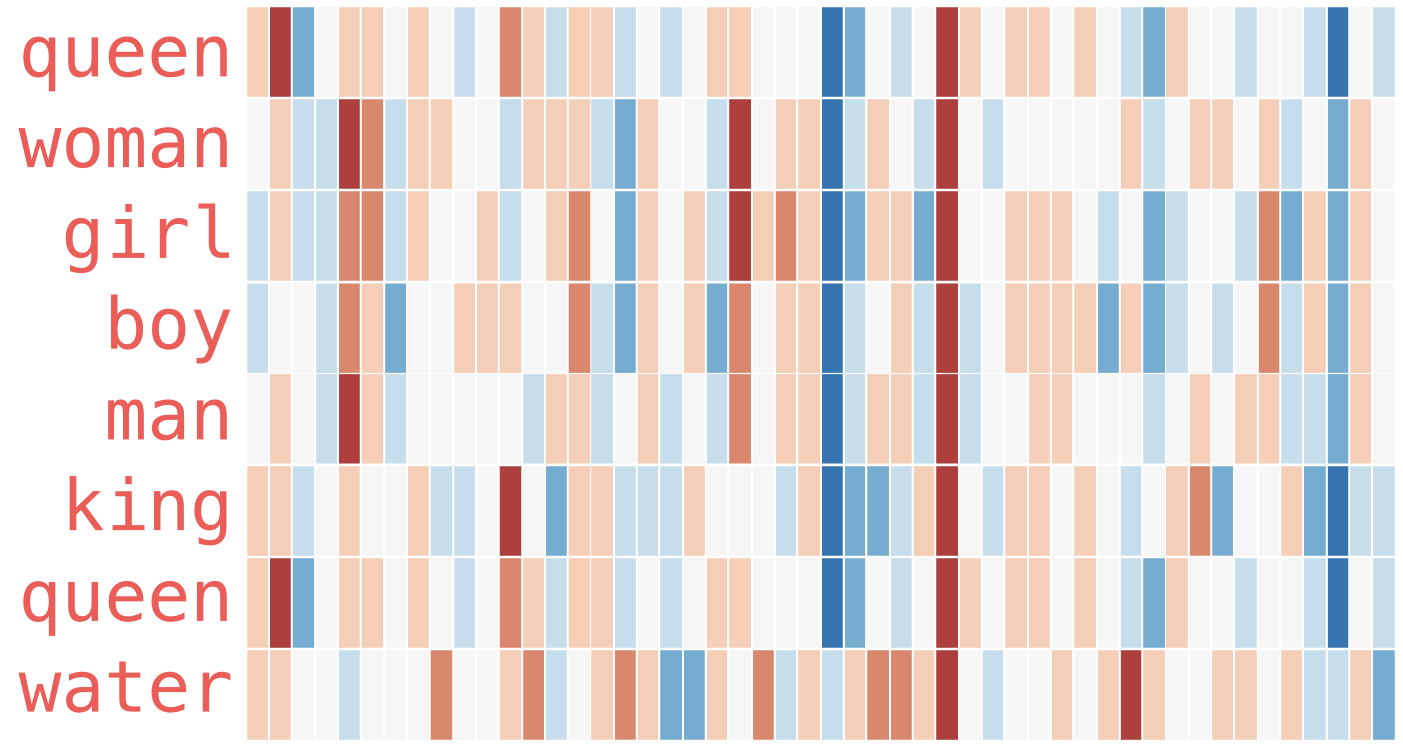

In [2]:
# МЕНЯ ВСТАВИТЬ В САМОЕ НАЧАЛО ЛЮБОГО JupyterNotebook,
#   А ПРИ ПОВТОРНОЕ РАБОТЕ ВСЕГДА ЗАПУСКАТЬ!

# Тут имя папки, в которую все сохраняется. 
#  Менять это имя можно. 
#  На Google Drive должно быть та же папка
#  Регистр (ЗАГЛАВНЫЕ или строчные буквы) важен! 
FOLDER = "2023-TextAI" 

PATH = "drive/MyDrive/" + FOLDER  + "/"

from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs(PATH, exist_ok = True)

import sys
sys.path.append(PATH)

Mounted at /content/drive


# Работа с данными



In [3]:
# Скачиваем данные
!gdown 1_qz6EISp2bvK1zp3U6IfzYyOXyaEX3-o

Downloading...
From: https://drive.google.com/uc?id=1_qz6EISp2bvK1zp3U6IfzYyOXyaEX3-o
To: /content/data.csv.zip
100% 83.9M/83.9M [00:02<00:00, 31.6MB/s]


In [4]:
!cp data.csv.zip {PATH}

In [5]:
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
import gensim

from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

from collections import Counter

tqdm.pandas()
random.seed(42)
np.random.seed(42)

<ipython-input-5-ef2f618029f9>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Загрузка данных

In [6]:
data = pd.read_csv("data.csv.zip", index_col="id")
data.head()

,emotion,date,flag,user,text
id,,,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
data["date"] = pd.to_datetime(data["date"].str.replace(" PDT ", " "), format="%a %b %d %H:%M:%S %Y")
data.head()

,emotion,date,flag,user,text
id,,,,,
1467810369,0,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1467810672,0,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1467810917,0,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
1467811184,0,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 1467810369 to 2193602129
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   emotion  1600000 non-null  int64         
 1   date     1600000 non-null  datetime64[ns]
 2   flag     1600000 non-null  object        
 3   user     1600000 non-null  object        
 4   text     1600000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 73.2+ MB


<Axes: xlabel='emotion', ylabel='count'>

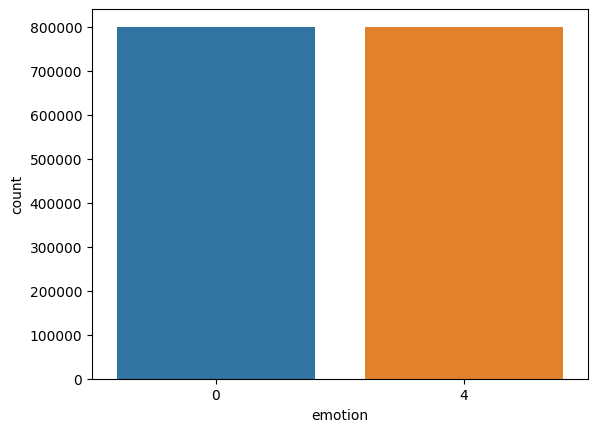

In [9]:
sns.countplot(data=data, x="emotion")

## Чистка текста

In [10]:
PUNCT_TO_REMOVE = string.punctuation + "«»№"
URL_PATTERN = r'https?://\S+|www\.\S+' # https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)
HTML_PATTERN = '<.*>'
USERNAME_PATTERN = "@\w+\s"
DIGIT_PATTERN = "\d+"
regex_pattern = re.compile(f"({URL_PATTERN}|{HTML_PATTERN}|{USERNAME_PATTERN}|{DIGIT_PATTERN})")

In [11]:
example_text = data.iloc[0, -1]

text = regex_pattern.sub("", example_text).split()
text = [i.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE))) for i in text]
text = [''.join(i for i in word if not i.isdigit()) for word in text]

example_text, " ".join(text)

("@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 '  Awww  that s a bummer  You shoulda got David Carr of Third Day to do it   D')

In [13]:
cnt = Counter()

def clean_words(row) -> str:
    text = row["text"].lower()
    text = regex_pattern.sub("", text).split()
    text = [i.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE))) for i in text]
    text = [''.join(i for i in word if not i.isdigit()) for word in text]

    for word in text:
        cnt[word] += 1
    return " ".join(text)

In [14]:
data["text"] = data.progress_apply(clean_words, axis=1)

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [15]:
data.to_csv(f'{PATH}/data_cleaned.csv.zip')

In [17]:
data = pd.read_csv(f'{PATH}/data_cleaned.csv.zip')

In [29]:
is_null = data["text"].isnull()
is_null.sum()

2823

In [32]:
data.loc[is_null,"text"] = ""

## Распространенные слова


In [31]:
cnt.most_common(10)

[('i', 746610),
 ('to', 560333),
 ('the', 518757),
 ('a', 377257),
 ('my', 312864),
 ('and', 295634),
 ('you', 237750),
 ('is', 231041),
 ('for', 214049),
 ('in', 210083)]

In [33]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["text"])

CPU times: user 25.8 s, sys: 755 ms, total: 26.6 s
Wall time: 27 s


In [34]:
X.shape

(1600000, 286750)

In [35]:
X = pd.Series(sorted(np.squeeze(np.asarray((X != 0).sum(axis=0)))))
X[-10:]

286740    170395
286741    199622
286742    201562
286743    219734
286744    244485
286745    261769
286746    272040
286747    282511
286748    427819
286749    458172
dtype: int64

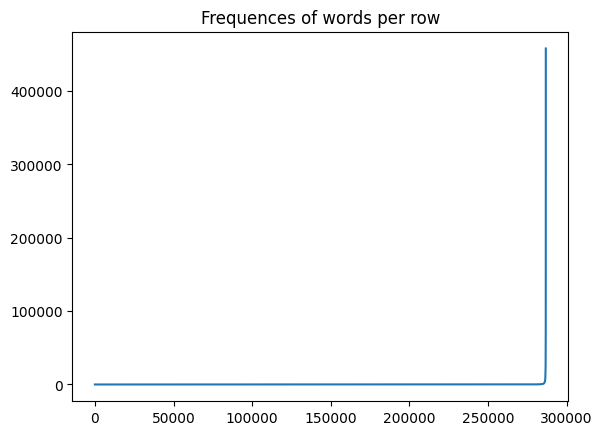

In [36]:
plt.plot(X)
plt.title("Frequences of words per row");

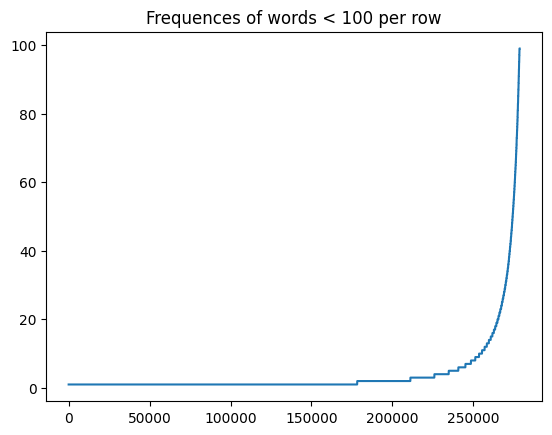

In [37]:
plt.plot(X[X<100])
plt.title("Frequences of words < 100 per row");

# Word2Vec


## Примеры Word2Vec

In [40]:
%%time
from gensim import downloader

#wv = downloader.load('word2vec-google-news-300') # Очень большая
wv = downloader.load('glove-twitter-25') # Не совсем Word2Vec, но для демонстрации хватит


[==================================================] 100.0% 104.8/104.8MB downloaded
CPU times: user 59.8 s, sys: 2.67 s, total: 1min 2s
Wall time: 1min 23s


In [41]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


![](https://raw.githubusercontent.com/amanjeetsahu/Natural-Language-Processing-Specialization/d562105e68a0b85012ad3ebbb29b2af6344ad4e5/Natural%20Language%20Processing%20with%20Classification%20and%20Vector%20Spaces/Week%203/vectors.jpg)

$$cos(X,Y) = \frac{<X, Y>}{||X||*||Y||}$$

Поиск ближайших соседей из примера с помощью gensim

In [49]:
wv.most_similar(positive=['king', "woman"], negative=["man"], topn=5) # cosine similarity for W2V

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949)]

Рассчет схожести известных слов с помощью sklearn



In [43]:
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
computed_vector = [wv["king"]-wv["man"]+wv["woman"]]
intresting_words = ["queen", "prince", "princess"]
for word, result in zip(intresting_words, cosine_similarity(computed_vector, wv[intresting_words])[0]):
    print(f"Result for {word=} is {result=}")

Result for word='queen' is result=0.7530913
Result for word='prince' is result=0.7605474
Result for word='princess' is result=0.6824288


Рассчет схожести известных слов на numpy

In [45]:
(computed_vector @ wv["queen"]) / (np.linalg.norm(computed_vector) * np.linalg.norm(wv["queen"]))

array([0.7530913], dtype=float32)

Тренируемся на котятах и щенках
![](https://petstory.ru/resize/800x800x80/upload/images/articles//kotyenok-i-shchenok-v-odnoy-kvartire/kitt-and-pupp1.jpg)

In [50]:
# Для примера

wv.most_similar(positive=["puppy", "cat"], negative=["dog"], topn=5)

[('kitten', 0.9398013949394226),
 ('kitty', 0.9168251156806946),
 ('monkey', 0.8665547370910645),
 ('owl', 0.8657613396644592),
 ('doggy', 0.861814558506012)]

## Применение Word2Vec

Тк будут классифицироваться твиты, то надо получать эмбединг самого твита. В данном случае будут усредняться все слова для которых известен вектор.

In [51]:
emb_line = np.mean([wv.get_vector(w) for w in data.iloc[0, -1].split() if w in wv], axis=0)
print(emb_line.shape)
print(emb_line)

(25,)
[ 0.01275918  0.3783      0.26857814 -0.09810553 -0.28757185 -0.14726429
  0.7814658   0.22118823 -0.21822335 -0.40642798 -0.23787588  0.05436118
 -4.2523656  -0.07335228  0.23735543 -0.20234807  0.16559085 -0.1915705
 -0.21897423 -0.1164306   0.04481166  0.2739632   0.26046303  0.22364709
 -0.16728576]


In [53]:
mean = np.mean(wv.vectors, 0)
std = np.std(wv.vectors, 0)

emb_line = np.mean([(wv.get_vector(w) - mean) / std for w in data.iloc[0, -1].split() if w in wv], axis=0)
print(emb_line.shape)
print(emb_line)

(25,)
[ 0.5418681   0.0666009   0.25358456 -0.14372444 -0.1527933   0.24198481
  1.3964447   1.3237357  -0.57213163  0.02572083  0.02322836 -0.25143954
 -5.2126303  -0.05285202  0.04484933 -0.6432597  -0.12959705 -0.3371484
 -1.0387126  -0.4231328  -0.05462204  0.06145263  0.21464571  0.27547774
  0.16824484]


In [54]:
mean = np.mean(wv.vectors, 0)
std = np.std(wv.vectors, 0)

def compute_embedding(row) -> np.ndarray:
    embeddings = [(wv.get_vector(w) - mean) / std for w in row["text"] if w in wv]# Получи эмбеддинги слов и усредни их

    if len(embeddings) == 0:
        embeddings = np.zeros((1, wv.vector_size))
    else:
        embeddings = np.array(embeddings)
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(-1, 1)
    return np.mean(embeddings, axis=0, dtype=np.float16)

In [55]:
X = np.stack(data.progress_apply(compute_embedding, axis=1))
y = data["emotion"]

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [56]:
data = None
wv = None

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1280000, 25), (1280000,), (320000, 25), (320000,))

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [59]:
%%time
clf = LogisticRegression(random_state=0)
clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 30.3 s, sys: 10.9 s, total: 41.2 s
Wall time: 24.9 s


In [62]:
f"{f1_score(predicted, y_test.values, pos_label=0)=}, {accuracy_score(predicted, y_test.values)=}"

'f1_score(predicted, y_test.values, pos_label=0)=0.5685133440747256, accuracy_score(predicted, y_test.values)=0.562309375'

In [63]:
clf = None
X = None
X_train = None
X_test = None
y_train = None
y_test = None
vectorizer = None
y = None
predicted = None

## Обучение Word2Vec

In [64]:
import gensim.models

In [ ]:
data = pd.read_csv(f'{PATH}/data_cleaned.csv.zip')

In [ ]:
is_null = data["text"].isnull()
is_null.sum()

2823

In [66]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, sentences: list[str]):
        self.sentences = sentences

    def __iter__(self):
        for line in self.sentences:
            # assume there's one document per line, tokens separated by whitespace
            yield line.split()

In [67]:
corpus = MyCorpus(data["text"].values)

In [70]:
%%time
model = gensim.models.Word2Vec(sentences=corpus, vector_size=25, sg=0) # sg=0 -- CBOW, sg=1 -- SKIP GRAMM

CPU times: user 5min 47s, sys: 1.61 s, total: 5min 49s
Wall time: 3min 56s


In [73]:
model.wv.most_similar(positive=['king', "woman"], negative=["man"], topn=5) # cosine similarity

[('animal', 0.7354238629341125),
 ('bond', 0.7201212644577026),
 ('pole', 0.7117068767547607),
 ('sex', 0.6986674070358276),
 ('scene', 0.6916687488555908)]

In [74]:
mean = np.mean(model.wv.vectors, 0)
std = np.std(model.wv.vectors, 0)

def compute_embedding(row) -> np.ndarray:
    embeddings = [(model.wv.get_vector(w) - mean) / std for w in row["text"] if w in model.wv]# Получи эмбеддинги слов и усредни их

    if len(embeddings) == 0:
        embeddings = np.zeros((1, model.wv.vector_size))
    else:
        embeddings = np.array(embeddings)
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(-1, 1)
    return np.mean(embeddings, axis=0, dtype=np.float16)

In [ ]:
X = np.stack(data.progress_apply(compute_embedding, axis=1))
y = data["emotion"]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1280000, 25), (1280000,), (320000, 25), (320000,))

In [ ]:
%%time
clf = LogisticRegression(random_state=0)
clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

In [ ]:
f1_score(predicted, y_test.values, pos_label=0), accuracy_score(predicted, y_test.values)

(0.5771304621110817, 0.5711125)

In [ ]:
print()